# Including 
* Single Particle 
* First Band Approximation Functions

In [1]:
using NBInclude
@nbinclude("Kagome SP.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Model Parameters

In [2]:
# Lattice sizes
Nx = 6; Ny = 4; N=Nx*Ny*3; cut_off = Nx*Ny;

# Total particle number array
PN = [0,1,2];

# Lattice potential
U = 2;

# Model hopping parameters
t1 = -1; L1 = 0.28; t2 = 0.3; L2 = 0.2;

# Sub-Space Operators of Single-Particle Space

In [3]:
sp_basis = NLevelBasis(N)
sp_matrix = dense(get_SP_H(Nx, Ny, t1, L1, t2, L2)).data;

In [4]:
#H1 = get_sp_op_data(sp_basis, N, sp_matrix);
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [5]:
using LinearAlgebra
#check operator form
eigenenergies(dense(H1)) == eigvals(sp_matrix)

true

In [6]:
eigvals(sp_matrix);

In [7]:
sub_states = get_sub_states(H1, cut_off);

In [8]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [9]:
H1_sub = get_subspace_op(H1, P, Pt);

In [10]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Hubbard Interaction in The Sub-Space

In [11]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [12]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [13]:
# Differ by numerical result
eigvals(dense(H1_MB).data);
eigenenergies(dense((H1_MB'+H1_MB)/2));

In [14]:
@nbinclude("Kagome MB .ipynb"; regex=r"#.*executeme");

In [15]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
# Interaction part
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Total Hamiltonian with Impurity Potential

In [16]:
# Kinetic part
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

function get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int)
    V_imp = V * number_mb_list_operators[imp_site]
    H_totall = H1cut + H_Int + V_imp
    return H_totall
end

get_total_H (generic function with 1 method)

In [18]:
imp_site = 23
V = 4

H_total_imp = get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int);
#H_total = get_total_H(0, imp_site, number_mb_list_operators, H1cut, H_Int)

#eigenenergies(dense((H_total+H_total')/2));

# Exact Diagonalization

In [19]:
using DataFrames

E, V = eigenstates(dense((H_total_imp+dagger(H_total_imp))/2))
#E0, V0 = eigenstates(dense((H_total+dagger(H_total))/2))

function get_energies(pn, E, V, basis)
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), V[i])) 
        PN_Energies[i,2] = E[i] 
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [20]:
PN

3-element Vector{Int64}:
 0
 1
 2

<font size="4">
    \begin{align*}
    \text{The number of degeneracy (}D\text{)} = \frac{(N_d+N-1)!}{N_d!(N-1)!}\frac{N_\phi}{N}=\frac{(2+2-1)!}{2!(2-1)}\frac{6}{2}=9
    \end{align*}
<end font>

In [23]:
pn = 2.0

df = get_energies(pn, E, V, basis_cut_mb)
#df_0 = get_energies(pn, E0, V0, basis_cut_mb)

# V \neq 0
filtered_energies = Matrix(df)[:,2]
# V = 0
#filtered_energies_0 = Matrix(df_0)[:,2];

show(stdout,"text/plain", filtered_energies)

300-element Vector{Float64}:
 -5.593665658601959
 -5.567788655335876
 -5.56736517407149
 -5.566969366517373
 -5.565681625604628
 -5.565058427087733
 -5.5647428092148274
 -5.563890307693597
 -5.562711379537622
 -5.56219642019029
 -5.562141324406941
 -5.56148836618948
 -5.561368072240313
 -5.558885281408629
 -5.557214193913863
 -5.555941537992368
 -5.554525456489625
 -5.554368398591341
 -5.553948700831057
 -5.553768483590734
 -5.553739435337871
 -5.552536587244722
 -5.551750566677448
 -5.547572840571341
 -5.5475492422483255
 -5.54698316841807
 -5.545207993259316
 -5.5452073479849275
 -5.5445420805817145
 -5.544500522568454
 -5.544229686709184
 -5.544005561210785
 -5.543293328690466
 -5.543114659464
 -5.543050341596938
 -5.542810142377662
 -5.542648749901892
 -5.542476684298548
 -5.542342498419893
 -5.5421132563125655
 -5.542070021972243
 -5.541920600181631
 -5.541827201977238
 -5.541792158684754
 -5.541412984324441
 -5.541376031386976
 -5.541263160641248
 -5.541120326292036
 -5.540964305

In [131]:
# # BUNA DAHA SONRA DÖN!
# using Plots
# using LaTeXStrings

# Plots.plot(1:20, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [132]:
# Eigenstates of filtered particles
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [133]:
r_hubbard_states = Restricted_Hubbard_States(V)
r_hubbard_states_0 = Restricted_Hubbard_States(V0);

# Densities

In [134]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            #NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
            # NOT: num_mb_list ile number_mb_list_operators bazları farklı ama içerikleri aynı!
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

In [135]:
BL = BR = basis_cut_mb
index_number_op = 4

T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)

index_eigen_states = 1

expect(Op, r_hubbard_states[index_eigen_states])
expect(Op, r_hubbard_states_0[index_eigen_states])

0.022227855051988196 - 2.6914471899005393e-19im

<font size="4">
$\sum_{i} <\psi_j|n_i|\psi_j>, \quad \text{for a given j index}$
</font>

In [136]:
index_eig_states = 1

function get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states)
    Sum = 0
    expect_list = []
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)   
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        push!(expect_list, expect(Op, r_hubbard_states[index_eig_states]))
    end
    return real(expect_list)
end

get_density_profiles (generic function with 1 method)

In [137]:
# BURAYA DAHA SONRA DÖN!

<font size="4">
    \begin{align*}
    \frac{N}{N_{\Phi}} &= \frac{2}{6}, \quad \text{In the Laughlin State: } \frac{N}{N_{\Phi}}=\frac{2}{4}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles.}
    \end{align*}
</font>

In [138]:
# AVERAGE (Nx=3; Ny=3; N=Nx*Ny*3; p=1; cut_off=Nx*Ny; PN=[0,1,2])

# Degeneracy in The Sub-Space for V \neq 0
Degeneracy = 8 
# avg_density = zeros((Nx,Ny)) 
# for index_eig_states in 1:Degeneracy
#     avg_density += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states),Nx,Ny)
# end    
# avg_density = avg_density / Degeneracy;
avg_density = get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states) ./ Degeneracy;

# Degeneracy in The Sub-Space for V = 0
# Degeneracy_0 = ?
# avg_density_0 = zeros((Nx,Ny))
# for index_eig_states in 1:Degeneracy_0
#     avg_density_0 += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states_0, index_eig_states),Nx,Ny)
# end    
# avg_density_0 = avg_density_0 / Degeneracy_0;

# Degeneracy_0 => Örgüde sadece 2 quasi-parçacık boştayken geçerli dejenereliktir.
# Ancak bizim bakmak istediğimiz resim, bu parçacıklardan birisini pinlenmiş ve diğerinin ise boşta olmasıdır.

# Lattice and Minimum Distances

In [139]:
c = get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[1]
coordinates = hcat(first.(c), last.(c));

In [140]:
# Ghost Sites
coordinates_top_left = (coordinates.-(Nx*a1_vec)).+(Ny*a2_vec)
coordinates_top = coordinates.+(Ny*a2_vec)
coordinates_top_right = (coordinates.+(Nx*a1_vec)).+(Ny*a2_vec)
coordinates_left = coordinates.-(Nx*a1_vec)
coordinates_right = coordinates.+(Nx*a1_vec)
coordinates_bottom_left = (coordinates.-(Nx*a1_vec)).-(Ny*a2_vec)
coordinates_bottom = coordinates.-(Ny*a2_vec)
coordinates_bottom_right = (coordinates.+(Nx*a1_vec)).-(Ny*a2_vec)
co_districts = [coordinates_top_left,coordinates_top,coordinates_top_right,coordinates_left,coordinates_right,coordinates,coordinates_bottom_left,coordinates_bottom,coordinates_bottom_right];

In [141]:
# using Plots
# center_x = coordinates[N,1]/2
# center_y = coordinates[N,2]/2
# scatter([coordinates_top_left[:,1]],[coordinates_top_left[:,2]],legend=false, alpha=0.3)
# scatter!([coordinates_top[:,1]],[coordinates_top[:,2]], alpha=0.3)
# scatter!([coordinates_top_right[:,1]],[coordinates_top_right[:,2]], alpha=0.3)
# scatter!([coordinates_left[:,1]],[coordinates_left[:,2]], alpha=0.3)
# scatter!([coordinates[:,1]], [coordinates[:,2]])
# scatter!([coordinates_right[:,1]],[coordinates_right[:,2]], alpha=0.3)
# scatter!([coordinates_bottom_left[:,1]],[coordinates_bottom_left[:,2]], alpha=0.3)
# scatter!([coordinates_bottom[:,1]],[coordinates_bottom[:,2]], alpha=0.3)
# scatter!([coordinates_bottom_right[:,1]],[coordinates_bottom_right[:,2]], alpha=0.3)

In [142]:
# Distance Functions
function find_co(coordinates, p) # coordinates: Distrincts of Periodic Site
    x_co = coordinates[:,1]
    y_co = coordinates[:,2]
    x = hcat(x_co, y_co)[p, 1]
    y = hcat(x_co, y_co)[p, 2]
    return x, y
end

function distance(coordinates_p1, p1, coordinates_p2, p2)
    x2 = find_co(coordinates_p2, p2)[1]
    x1 = find_co(coordinates_p1, p1)[1]
    y2 = find_co(coordinates_p2, p2)[2]
    y1 = find_co(coordinates_p1, p1)[2]
    return sqrt( (x2 - x1)^2 + (y2 - y1)^2 )
end

distance (generic function with 1 method)

In [143]:
# Example of Disctance Function
coordinates_p1=coordinates
p1 = 1
coordinates_p2=coordinates
p2 = 5
distance(coordinates_p1, p1, coordinates_p2, p2)

2.6457513110645907

# Minimum Distances of Equivalent Sites from Center Reference Site

In [144]:
ref_coordinates = coordinates
ref_site = imp_site # Site That Pinned
distances = []
for site_idx in 1:N 
    push!(distances, distance(coordinates, site_idx, ref_coordinates, ref_site))
end
radius_list = sort(unique(distances));

# Density Plot and $Q_{\rho}$ Calculation with Equivalent Sites Conditions

In [145]:
# Find x and y coordinates from given site index

function exp_list0(site_indx)
    
    x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:N)
    y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:N)
    
    x = hcat(x_co, y_co)[site_indx, 1]
    y = hcat(x_co, y_co)[site_indx, 2] 
    
    #!!! 
    # Burada beklenen değerlerin sıralamasının site bazında olduğunu varsaydım!!!!
    #!!!
    exp_val = real(avg_density)[site_indx] 
    
    return x, y, exp_val
end
exp_list0(2)

(1.0, 0.0, 0.0029785585574554994)

In [146]:
# Find site_index from given x and y coordinates

function exp_list1(Xx, Yy)
    co_list = hcat(x_co, y_co)
    site_indx = intersect(findall(x->x==Xx, co_list[:,1]), findall(x->x==Yy, co_list[:,2]))
    return real(avg_density)[site_indx] 
end

x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:N)
y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:N)
site_index = 2
Xx = x_co[site_index]
Yy = y_co[site_index]
print(site_index," => ",Xx,"\t",Yy," => ",exp_list1(Xx, Yy))

2 => 1.0	0.0 => [0.0029785585574554994]

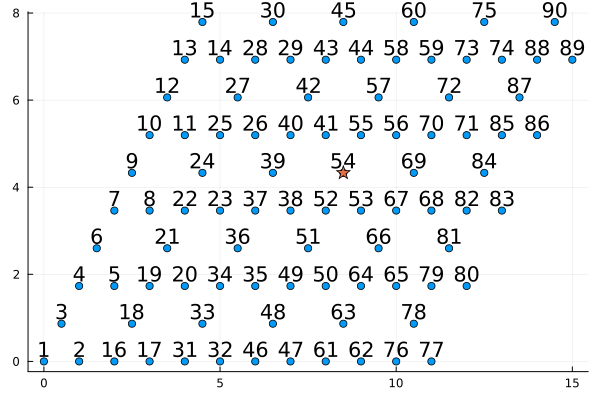

In [147]:
scatter(x_co,y_co,legend=false,series_annotations = text.(1:N, :bottom))
x_imp = exp_list0(imp_site)[1];y_imp=exp_list0(imp_site)[2]
scatter!([x_imp], [y_imp],markershape=:star5,markersize=7)

In [148]:
# using Plots
# using Interpolations

# function Interp2D(data, factor)
    
#     IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)

#     finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
#     finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
#     nx = length(finerx)
#     ny = length(finery)

#     data_interp = Array{Float64}(undef,nx,ny)
#     for i ∈ 1:nx, j ∈ 1:ny
#         data_interp[i,j] = IC(finerx[i],finery[j])
#     end

#     return finery, finerx, data_interp

# end

# data = reshape(z,9,3)
# factor = 20

# Plots.heatmap(Interp2D(data, factor))

# # center_x = x_co[imp_site]; center_y = y_co[imp_site]
# # Plots.scatter!([center_x], [center_y], color=:red, markersize=5, marker= :star5)

# # Plots.scatter!(x_co, y_co, color=:black, markersize=1, legend=false)

In [149]:
z = exp_list1.(x_co, y_co)
z = collect(Iterators.flatten(z));

In [150]:
z[imp_site]

1.746973607139782e-6

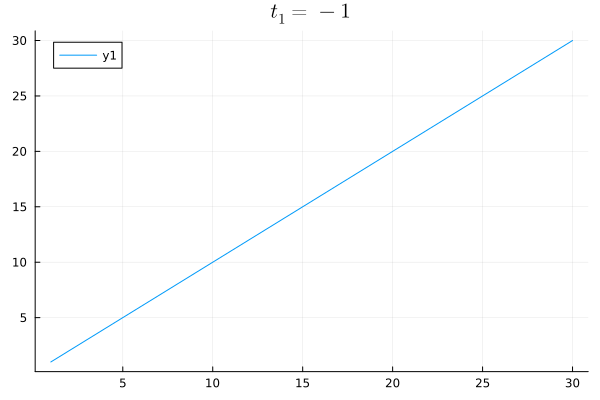

In [180]:
using Plots
using LaTeXStrings
threshold = 30
st="\$ t_1=$t1 \$"
plot(1:30)
title!(st)

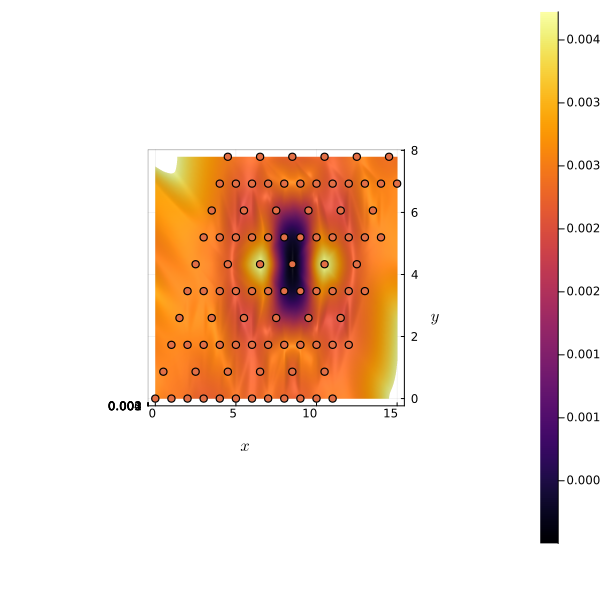

In [213]:
density = exp_list1.(x_co, y_co)
density = collect(Iterators.flatten(z))
surface(x_co,y_co,z,xlabel=L"$x$",ylabel=L"$y$", camera = (0,90), size=(600,600))
# st="\$ i_1=$Nx, i_2=$Ny, PN=$pn \$"
# title!(st)
#title!("t1=$(t1),L1=$(L1),t2=$(t2),L2=$(L2) \n Nx=$(Nx), Ny=$(Ny), N=$(N), Cut-off=$(cut_off) \n PN=$(pn), U=$(U), V_imp=$(V) \n V_imp_site=$(imp_site)")

# Plot kagome as project to the plot of density profile
scatter!(x_co, y_co, 0. *density, camera=(0,90), legend=false)

In [27]:
#U çok küçükken (Band-Gap büyüdüğünde) subspace enerjileri, real-space enerjilerine yakınsar:

# MB_Hamiltonian = Kagome_Finite_U(Nx,Ny,Basis_MB,U,sp_op)
# real_space_finite_u = eigenenergies(dense(MB_Hamiltonian)); sub_space_finite_u = E_States[1]
# plot(1:length(real_space_finite_u[1:21]),real_space_finite_u,seriestype=:scatter,markershape=:star5,markersize=7,label="Real-Space")
# plot!(1:length(sub_space_finite_u),sub_space_finite_u,seriestype=:scatter,label="Sub-Space",legend=:topleft)
# title!("U=$(U)");xlabel!("n");ylabel!("E")